# FIFA Players Classification

This notebook contains the code to train models for the FIFA Classification problem based on their attributes

## Step 1: Import libraries

Libraries we will be using:
- **tensorflow** and **keras**: APIs for neural network model construction and training
- **numpy**: Numerical python library.
- **pandas**: Will be used to work with dataframes from .csv files.
- **sklearn**: Will be used to plot the confusion matrix.
- **matplotlib**: Will be used to plot graphics.
- **time**: To measure training time.
- **datetime**: To get the datetime a new model is created and use that to create its name

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import LearningRateScheduler,TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime

## Step 2: Load data

We first define the path to our data

In [2]:
DATA_FOLDER = "../Data"

ATT_FILE = f"{DATA_FOLDER}/FootballPlayerPreparedCleanAttributes.csv"
IMPUTED_ATT_FILE = f"{DATA_FOLDER}/ImputedFootballPlayerPreparedCleanAttributes.csv"

ONE_HOT_LABEL_FILE = f"{DATA_FOLDER}/FootballPlayerOneHotEncodedClasses.csv"
IMPUTED_ONE_HOT_LABEL_FILE = f"{DATA_FOLDER}/ImputedFootballPlayerOneHotEncodedClasses.csv"

Specify training options:
- **IMPUTED_DATA**: We will use file with data imputed
- **TRAIN_RATE**: The amount of instances to use during training, it will also determine the dev and test instances number indirectly

In [3]:
IMPUTED_DATA = False    # Use imputed dataset
TRAIN_RATE = 0.8        # The division of the data for training, validation and test

Because our data has more than 10000, we will be using 80-10-10 split in our dataset:
- **80%** for training
- **10%** for validation/dev test
- **10%** for final test

In [4]:
if IMPUTED_DATA:
    attributes = pd.read_csv(IMPUTED_ATT_FILE)
    labels = pd.read_csv(IMPUTED_ONE_HOT_LABEL_FILE)
else:
    attributes = pd.read_csv(ATT_FILE)
    labels = pd.read_csv(ONE_HOT_LABEL_FILE)

n_total_instances = attributes.shape[0]
n_train_instances = int(n_total_instances * TRAIN_RATE)
n_dev_instances = int((n_total_instances - n_train_instances)/2)

instances_train = attributes.values[:n_train_instances]
labels_train = labels.values[:n_train_instances]

instances_dev = attributes.values[n_train_instances: n_train_instances + n_dev_instances]
labels_dev = labels.values[n_train_instances: n_train_instances + n_dev_instances]

print("instances_train:", instances_train.shape)
print("labels_train:", labels_train.shape)
print("instances_dev:", instances_dev.shape)
print("labels_dev:",labels_dev.shape)

instances_train: (12897, 17)
labels_train: (12897, 4)
instances_dev: (1612, 17)
labels_dev: (1612, 4)


## Step 3: Initialize variables
- **INPUT_SIZE**: The size of the training instances
- **OUTPUT_SIZE**: The number of possible classes
- **NUM_TRAINING_EXAMPLES**: The number of possible classes
- **NUM_DEV_EXAMPLES**: The number of validation/dev test instances

In [5]:
INPUT_SIZE = instances_train.shape[1]
print(INPUT_SIZE)
OUTPUT_SIZE = labels_train.shape[1]
print(OUTPUT_SIZE)
NUM_TRAINING_EXAMPLES = int(round(instances_train.shape[0]/1))
NUM_DEV_EXAMPLES = int(round(instances_dev.shape[0]/1))

17
4


## Step 4: Set hyperparameters

- **LEARNING_RATE** $\alpha$: The step size in the learning process
- **BATCH_SIZE**: The size of each batch
- **N_HIDDEN**: Number of neurons in the hidden.

The learning process stops when it reaches 20,000 learning iterations. An iteration comprises presenting the network *batch_size* learning examples and then adjusting the weights (parameters).

In [6]:
N_EPOCHS = 5000
LEARNING_RATE = 0.01
BATCH_SIZE = 4096
ACTIVATION = "relu"
N_HIDDEN = [32, 16, 8]
REGULARIZER = keras.regularizers.L1L2(l1=0.001,l2=0.1)
INITIALIZER = keras.initializers.he_normal(seed=None)
LOSS = tf.keras.losses.categorical_crossentropy
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999)
METRICS = ["categorical_accuracy"]

## Step 5: Build the model

In [7]:
def architecture1():
    model = keras.Sequential(name="Model")
    model.add(keras.layers.InputLayer(input_shape=(INPUT_SIZE,), batch_size=None))
    for neurons in N_HIDDEN:
        model.add(keras.layers.Dense(neurons, activation=ACTIVATION))
    model.add(keras.layers.Dense(OUTPUT_SIZE, activation="softmax"))
    
    model_name = "D512"
    return model, model_name


def architecture2():
    model = keras.Sequential(name="Model")
    model.add(keras.layers.InputLayer(input_shape=(INPUT_SIZE,),
                                      batch_size=None))
    for neurons in N_HIDDEN:
        model.add(keras.layers.Dense(neurons,
                                     activation=ACTIVATION,
                                     kernel_regularizer=REGULARIZER
                                    ))
        
    model.add(keras.layers.Dense(OUTPUT_SIZE, 
                                 activation="softmax"))
    
    model_name = "D128_D64_D32"
    return model, model_name

def architecture3():
    model = keras.Sequential(name="Model")
    model.add(keras.layers.InputLayer(input_shape=(INPUT_SIZE,),
                                      batch_size=None))
    
    for neurons in N_HIDDEN:
        model.add(keras.layers.Dense(neurons))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation(ACTIVATION))
        
    model.add(keras.layers.Dense(OUTPUT_SIZE,
                                 activation="softmax"
                                ))
    model_name = "D128_BN_D64_BN_D32_BN"
    return model, model_name

def architecture4():
    model = keras.Sequential(name="Model")
    model.add(keras.layers.InputLayer(input_shape=(INPUT_SIZE,),
                                      batch_size=None))
    
    for neurons in N_HIDDEN:
        model.add(keras.layers.Dense(neurons,
                                     kernel_regularizer=REGULARIZER,
                                     kernel_initializer=keras.initializers.HeUniform(seed=None),
                                     use_bias=False
                                     ))
    
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation(ACTIVATION))
        
    model.add(keras.layers.Dense(OUTPUT_SIZE,
                                 activation="softmax"
                                ))
    model_name = "D2048_BN_D1024_BN_D512_BN_D256_BN_D128_BN_D64_BN_D32_BN"
    return model, model_name


def architecture5():
    model = keras.Sequential(name="Model")
    model.add(keras.layers.InputLayer(input_shape=(INPUT_SIZE,),
                                      batch_size=None))
    
    for neurons in N_HIDDEN:
        model.add(keras.layers.Dense(neurons,
                                     kernel_regularizer=REGULARIZER,
                                     kernel_initializer=keras.initializers.HeNormal(seed=None),
                                     use_bias=False
                                     ))
    
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation(ACTIVATION))
        
    model.add(keras.layers.Dense(OUTPUT_SIZE,
                                 activation="softmax"
                                ))
    
    model_name = "D512_BN_D128_BN_D32_BN_D128_BN_D512_BN"
    return model, model_name

def architecture5dr():
    model = keras.Sequential(name="Model")
    model.add(keras.layers.InputLayer(input_shape=(INPUT_SIZE,),
                                      batch_size=None))
    
    for neurons in N_HIDDEN:
        model.add(keras.layers.Dense(neurons,
                                     kernel_regularizer=REGULARIZER,
                                     kernel_initializer=keras.initializers.HeNormal(seed=None),
                                     use_bias=False
                                     ))
        model.add(keras.layers.Dropout(rate=0.1))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation(ACTIVATION))
        
    model.add(keras.layers.Dense(OUTPUT_SIZE,
                                 activation="softmax"
                                ))
    
    model_name = "D512_DR_BN_D128_DR_BN_D32_DR_BN_D128_DR_BN_D512_DR_BN"
    return model, model_name


def final_architecture():
    model = keras.Sequential(name="Model")
    model.add(keras.layers.InputLayer(input_shape=(INPUT_SIZE,),
                                      batch_size=None))
    
    for neurons in N_HIDDEN:
        model.add(keras.layers.Dense(neurons,
                                     kernel_regularizer=REGULARIZER,
                                     kernel_initializer=keras.initializers.HeNormal(seed=None),
                                     use_bias=False
                                     ))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation(ACTIVATION))
        
    model.add(keras.layers.Dense(OUTPUT_SIZE,
                                 activation="softmax"
                                ))
    
    model_name = "final"
    return model, model_name
    
    
def compile_model(model):
    my_model.compile(loss=LOSS,
                     optimizer=OPTIMIZER,
                     metrics=METRICS)

In [8]:
my_model, model_name = final_architecture()

In [9]:
compile_model(my_model)

## Step 6: Train the model

In [10]:
checkpoint_filepath = "../Models/finalsin.h5"
reduce_lr = ReduceLROnPlateau('val_categorical_accuracy', factor=0.1, patience=150, verbose=1)
early_stop = EarlyStopping('val_categorical_accuracy', patience=500, verbose=1)
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_categorical_accuracy',mode='max',save_best_only=True)
callbacks = [reduce_lr,checkpoint]#,reduce_lr]
start_time = time.perf_counter()
history = my_model.fit(instances_train, 
                       labels_train, 
                       batch_size = BATCH_SIZE, 
                       epochs=N_EPOCHS, 
                       validation_data = (instances_dev, labels_dev),
                       callbacks=callbacks,
                       verbose = 1)

end_time = time.perf_counter()
best_idx = int(np.argmax(history.history['val_categorical_accuracy']))
best_value = np.max(history.history['val_categorical_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_categorical_accuracy ' + str(best_value))

Epoch 1/5000
4/4 [==============================] - 2s 96ms/step - loss: 12.4669 - categorical_accuracy: 0.2555 - val_loss: 10.7076 - val_categorical_accuracy: 0.3046 - lr: 0.0100
Epoch 2/5000
4/4 [==============================] - 0s 18ms/step - loss: 10.1348 - categorical_accuracy: 0.3978 - val_loss: 8.8618 - val_categorical_accuracy: 0.2667 - lr: 0.0100
Epoch 3/5000
4/4 [==============================] - 0s 18ms/step - loss: 8.2811 - categorical_accuracy: 0.4413 - val_loss: 7.3089 - val_categorical_accuracy: 0.2581 - lr: 0.0100
Epoch 4/5000
4/4 [==============================] - 0s 19ms/step - loss: 6.7404 - categorical_accuracy: 0.4759 - val_loss: 6.0294 - val_categorical_accuracy: 0.2680 - lr: 0.0100
Epoch 5/5000
4/4 [==============================] - 0s 26ms/step - loss: 5.4762 - categorical_accuracy: 0.5207 - val_loss: 5.0006 - val_categorical_accuracy: 0.3263 - lr: 0.0100
Epoch 6/5000
4/4 [==============================] - 0s 25ms/step - loss: 4.4506 - categorical_accuracy: 0.5

Epoch 47/5000
4/4 [==============================] - 0s 20ms/step - loss: 0.4872 - categorical_accuracy: 0.8051 - val_loss: 1.9803 - val_categorical_accuracy: 0.2339 - lr: 0.0100
Epoch 48/5000
4/4 [==============================] - 0s 19ms/step - loss: 0.4929 - categorical_accuracy: 0.8007 - val_loss: 1.9903 - val_categorical_accuracy: 0.2339 - lr: 0.0100
Epoch 49/5000
4/4 [==============================] - 0s 19ms/step - loss: 0.4957 - categorical_accuracy: 0.8017 - val_loss: 2.0127 - val_categorical_accuracy: 0.2339 - lr: 0.0100
Epoch 50/5000
4/4 [==============================] - 0s 19ms/step - loss: 0.4839 - categorical_accuracy: 0.8087 - val_loss: 2.0377 - val_categorical_accuracy: 0.2339 - lr: 0.0100
Epoch 51/5000
4/4 [==============================] - 0s 18ms/step - loss: 0.5065 - categorical_accuracy: 0.7964 - val_loss: 2.0246 - val_categorical_accuracy: 0.2339 - lr: 0.0100
Epoch 52/5000
4/4 [==============================] - 0s 19ms/step - loss: 0.4871 - categorical_accuracy: 

Epoch 93/5000
4/4 [==============================] - 0s 18ms/step - loss: 0.4776 - categorical_accuracy: 0.8101 - val_loss: 1.9782 - val_categorical_accuracy: 0.2339 - lr: 0.0100
Epoch 94/5000
4/4 [==============================] - 0s 19ms/step - loss: 0.4736 - categorical_accuracy: 0.8114 - val_loss: 1.9957 - val_categorical_accuracy: 0.2339 - lr: 0.0100
Epoch 95/5000
4/4 [==============================] - 0s 19ms/step - loss: 0.4829 - categorical_accuracy: 0.8035 - val_loss: 2.0809 - val_categorical_accuracy: 0.2339 - lr: 0.0100
Epoch 96/5000
4/4 [==============================] - 0s 19ms/step - loss: 0.4703 - categorical_accuracy: 0.8127 - val_loss: 2.1241 - val_categorical_accuracy: 0.2339 - lr: 0.0100
Epoch 97/5000
4/4 [==============================] - 0s 18ms/step - loss: 0.4696 - categorical_accuracy: 0.8110 - val_loss: 2.0946 - val_categorical_accuracy: 0.2339 - lr: 0.0100
Epoch 98/5000
4/4 [==============================] - 0s 18ms/step - loss: 0.4863 - categorical_accuracy: 

4/4 [==============================] - 0s 23ms/step - loss: 0.4693 - categorical_accuracy: 0.8119 - val_loss: 1.4179 - val_categorical_accuracy: 0.5099 - lr: 0.0100
Epoch 139/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.4730 - categorical_accuracy: 0.8096 - val_loss: 1.2663 - val_categorical_accuracy: 0.5744 - lr: 0.0100
Epoch 140/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.4758 - categorical_accuracy: 0.8097 - val_loss: 1.0880 - val_categorical_accuracy: 0.5695 - lr: 0.0100
Epoch 141/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4783 - categorical_accuracy: 0.8064 - val_loss: 0.9461 - val_categorical_accuracy: 0.6185 - lr: 0.0100
Epoch 142/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4825 - categorical_accuracy: 0.8033 - val_loss: 1.0222 - val_categorical_accuracy: 0.5893 - lr: 0.0100
Epoch 143/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.4940 - categorical_accuracy: 0.7992 - 

Epoch 184/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.4924 - categorical_accuracy: 0.7965 - val_loss: 0.8859 - val_categorical_accuracy: 0.6427 - lr: 0.0100
Epoch 185/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.4787 - categorical_accuracy: 0.8047 - val_loss: 0.7614 - val_categorical_accuracy: 0.7010 - lr: 0.0100
Epoch 186/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.4707 - categorical_accuracy: 0.8117 - val_loss: 0.5703 - val_categorical_accuracy: 0.7525 - lr: 0.0100
Epoch 187/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.4807 - categorical_accuracy: 0.8039 - val_loss: 0.5522 - val_categorical_accuracy: 0.7630 - lr: 0.0100
Epoch 188/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.4797 - categorical_accuracy: 0.8096 - val_loss: 0.5625 - val_categorical_accuracy: 0.7643 - lr: 0.0100
Epoch 189/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.4849 - categorical_accu

4/4 [==============================] - 0s 25ms/step - loss: 0.4633 - categorical_accuracy: 0.8115 - val_loss: 0.7626 - val_categorical_accuracy: 0.6749 - lr: 0.0100
Epoch 230/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.4653 - categorical_accuracy: 0.8114 - val_loss: 0.7196 - val_categorical_accuracy: 0.6793 - lr: 0.0100
Epoch 231/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4598 - categorical_accuracy: 0.8137 - val_loss: 0.6308 - val_categorical_accuracy: 0.7351 - lr: 0.0100
Epoch 232/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.4736 - categorical_accuracy: 0.8086 - val_loss: 0.5862 - val_categorical_accuracy: 0.7395 - lr: 0.0100
Epoch 233/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.4611 - categorical_accuracy: 0.8120 - val_loss: 0.8133 - val_categorical_accuracy: 0.6638 - lr: 0.0100
Epoch 234/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4671 - categorical_accuracy: 0.8111 - 

Epoch 275/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.4551 - categorical_accuracy: 0.8158 - val_loss: 0.6665 - val_categorical_accuracy: 0.7295 - lr: 0.0100
Epoch 276/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.4612 - categorical_accuracy: 0.8120 - val_loss: 0.6027 - val_categorical_accuracy: 0.7481 - lr: 0.0100
Epoch 277/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.4477 - categorical_accuracy: 0.8203 - val_loss: 0.7577 - val_categorical_accuracy: 0.6911 - lr: 0.0100
Epoch 278/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.4659 - categorical_accuracy: 0.8094 - val_loss: 0.9008 - val_categorical_accuracy: 0.6532 - lr: 0.0100
Epoch 279/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4900 - categorical_accuracy: 0.8002 - val_loss: 0.5302 - val_categorical_accuracy: 0.7754 - lr: 0.0100
Epoch 280/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.4736 - categorical_accu

4/4 [==============================] - 0s 23ms/step - loss: 0.4606 - categorical_accuracy: 0.8155 - val_loss: 0.5543 - val_categorical_accuracy: 0.7779 - lr: 0.0100
Epoch 321/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4671 - categorical_accuracy: 0.8114 - val_loss: 0.5272 - val_categorical_accuracy: 0.7730 - lr: 0.0100
Epoch 322/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.4639 - categorical_accuracy: 0.8116 - val_loss: 0.5457 - val_categorical_accuracy: 0.7692 - lr: 0.0100
Epoch 323/5000
4/4 [==============================] - 0s 27ms/step - loss: 0.4604 - categorical_accuracy: 0.8123 - val_loss: 0.5298 - val_categorical_accuracy: 0.7754 - lr: 0.0100
Epoch 324/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4556 - categorical_accuracy: 0.8162 - val_loss: 0.7908 - val_categorical_accuracy: 0.6644 - lr: 0.0100
Epoch 325/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4565 - categorical_accuracy: 0.8162 - 

Epoch 366/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4728 - categorical_accuracy: 0.8083 - val_loss: 0.5128 - val_categorical_accuracy: 0.7854 - lr: 0.0100
Epoch 367/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.4690 - categorical_accuracy: 0.8103 - val_loss: 0.5106 - val_categorical_accuracy: 0.7860 - lr: 0.0100
Epoch 368/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4646 - categorical_accuracy: 0.8164 - val_loss: 0.5697 - val_categorical_accuracy: 0.7674 - lr: 0.0100
Epoch 369/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4747 - categorical_accuracy: 0.8055 - val_loss: 0.5096 - val_categorical_accuracy: 0.7878 - lr: 0.0100
Epoch 370/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4552 - categorical_accuracy: 0.8196 - val_loss: 0.5247 - val_categorical_accuracy: 0.7804 - lr: 0.0100
Epoch 371/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4602 - categorical_accu

4/4 [==============================] - 0s 26ms/step - loss: 0.4552 - categorical_accuracy: 0.8176 - val_loss: 0.4746 - val_categorical_accuracy: 0.8021 - lr: 0.0100
Epoch 412/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.4587 - categorical_accuracy: 0.8155 - val_loss: 0.4998 - val_categorical_accuracy: 0.7916 - lr: 0.0100
Epoch 413/5000
4/4 [==============================] - 0s 27ms/step - loss: 0.4497 - categorical_accuracy: 0.8172 - val_loss: 0.4955 - val_categorical_accuracy: 0.7872 - lr: 0.0100
Epoch 414/5000
4/4 [==============================] - 0s 27ms/step - loss: 0.4482 - categorical_accuracy: 0.8190 - val_loss: 0.5743 - val_categorical_accuracy: 0.7550 - lr: 0.0100
Epoch 415/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.4503 - categorical_accuracy: 0.8165 - val_loss: 0.6765 - val_categorical_accuracy: 0.7097 - lr: 0.0100
Epoch 416/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.4584 - categorical_accuracy: 0.8111 - 

Epoch 457/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4481 - categorical_accuracy: 0.8226 - val_loss: 0.7030 - val_categorical_accuracy: 0.6979 - lr: 0.0100
Epoch 458/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.4512 - categorical_accuracy: 0.8184 - val_loss: 0.5916 - val_categorical_accuracy: 0.7475 - lr: 0.0100
Epoch 459/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.4549 - categorical_accuracy: 0.8141 - val_loss: 0.6318 - val_categorical_accuracy: 0.7233 - lr: 0.0100
Epoch 460/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4598 - categorical_accuracy: 0.8135 - val_loss: 0.5824 - val_categorical_accuracy: 0.7395 - lr: 0.0100
Epoch 461/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.4550 - categorical_accuracy: 0.8149 - val_loss: 0.6417 - val_categorical_accuracy: 0.7221 - lr: 0.0100
Epoch 462/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.4614 - categorical_accu

4/4 [==============================] - 0s 24ms/step - loss: 0.4235 - categorical_accuracy: 0.8266 - val_loss: 0.9052 - val_categorical_accuracy: 0.6452 - lr: 1.0000e-03
Epoch 502/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.4239 - categorical_accuracy: 0.8276 - val_loss: 0.8981 - val_categorical_accuracy: 0.6402 - lr: 1.0000e-03
Epoch 503/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4238 - categorical_accuracy: 0.8278 - val_loss: 0.9568 - val_categorical_accuracy: 0.6216 - lr: 1.0000e-03
Epoch 504/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4210 - categorical_accuracy: 0.8285 - val_loss: 1.0021 - val_categorical_accuracy: 0.6148 - lr: 1.0000e-03
Epoch 505/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.4199 - categorical_accuracy: 0.8301 - val_loss: 1.0132 - val_categorical_accuracy: 0.6073 - lr: 1.0000e-03
Epoch 506/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.4213 - categorical

Epoch 546/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4132 - categorical_accuracy: 0.8273 - val_loss: 0.7791 - val_categorical_accuracy: 0.6743 - lr: 1.0000e-03
Epoch 547/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.4123 - categorical_accuracy: 0.8302 - val_loss: 0.7588 - val_categorical_accuracy: 0.6849 - lr: 1.0000e-03
Epoch 548/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.4165 - categorical_accuracy: 0.8269 - val_loss: 0.7519 - val_categorical_accuracy: 0.6842 - lr: 1.0000e-03
Epoch 549/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4151 - categorical_accuracy: 0.8269 - val_loss: 0.7862 - val_categorical_accuracy: 0.6756 - lr: 1.0000e-03
Epoch 550/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.4171 - categorical_accuracy: 0.8274 - val_loss: 0.7892 - val_categorical_accuracy: 0.6774 - lr: 1.0000e-03
Epoch 551/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.416

4/4 [==============================] - 0s 24ms/step - loss: 0.4105 - categorical_accuracy: 0.8294 - val_loss: 0.5183 - val_categorical_accuracy: 0.7717 - lr: 1.0000e-03
Epoch 591/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4082 - categorical_accuracy: 0.8292 - val_loss: 0.5439 - val_categorical_accuracy: 0.7661 - lr: 1.0000e-03
Epoch 592/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4083 - categorical_accuracy: 0.8297 - val_loss: 0.5546 - val_categorical_accuracy: 0.7537 - lr: 1.0000e-03
Epoch 593/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.4077 - categorical_accuracy: 0.8302 - val_loss: 0.5550 - val_categorical_accuracy: 0.7562 - lr: 1.0000e-03
Epoch 594/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4086 - categorical_accuracy: 0.8303 - val_loss: 0.5250 - val_categorical_accuracy: 0.7699 - lr: 1.0000e-03
Epoch 595/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.4119 - categorical

Epoch 635/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4089 - categorical_accuracy: 0.8274 - val_loss: 0.4867 - val_categorical_accuracy: 0.7872 - lr: 1.0000e-03
Epoch 636/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.4091 - categorical_accuracy: 0.8290 - val_loss: 0.4585 - val_categorical_accuracy: 0.8077 - lr: 1.0000e-03
Epoch 637/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4098 - categorical_accuracy: 0.8271 - val_loss: 0.4672 - val_categorical_accuracy: 0.8015 - lr: 1.0000e-03
Epoch 638/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.4066 - categorical_accuracy: 0.8293 - val_loss: 0.4680 - val_categorical_accuracy: 0.8009 - lr: 1.0000e-03
Epoch 639/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4094 - categorical_accuracy: 0.8267 - val_loss: 0.4972 - val_categorical_accuracy: 0.7785 - lr: 1.0000e-03
Epoch 640/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.409

4/4 [==============================] - 0s 24ms/step - loss: 0.4102 - categorical_accuracy: 0.8290 - val_loss: 0.4637 - val_categorical_accuracy: 0.7965 - lr: 1.0000e-03
Epoch 680/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4078 - categorical_accuracy: 0.8292 - val_loss: 0.4641 - val_categorical_accuracy: 0.7971 - lr: 1.0000e-03
Epoch 681/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.4094 - categorical_accuracy: 0.8293 - val_loss: 0.4716 - val_categorical_accuracy: 0.7996 - lr: 1.0000e-03
Epoch 682/5000
4/4 [==============================] - 0s 32ms/step - loss: 0.4081 - categorical_accuracy: 0.8322 - val_loss: 0.4479 - val_categorical_accuracy: 0.8158 - lr: 1.0000e-03
Epoch 683/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.4118 - categorical_accuracy: 0.8270 - val_loss: 0.4597 - val_categorical_accuracy: 0.8040 - lr: 1.0000e-03
Epoch 684/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.4118 - categorical

Epoch 724/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.4095 - categorical_accuracy: 0.8280 - val_loss: 0.4486 - val_categorical_accuracy: 0.8058 - lr: 1.0000e-03
Epoch 725/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4086 - categorical_accuracy: 0.8266 - val_loss: 0.4661 - val_categorical_accuracy: 0.7947 - lr: 1.0000e-03
Epoch 726/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.4240 - categorical_accuracy: 0.8227 - val_loss: 0.4662 - val_categorical_accuracy: 0.7947 - lr: 1.0000e-03
Epoch 727/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.4206 - categorical_accuracy: 0.8238 - val_loss: 0.4633 - val_categorical_accuracy: 0.8002 - lr: 1.0000e-03
Epoch 728/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4129 - categorical_accuracy: 0.8250 - val_loss: 0.4673 - val_categorical_accuracy: 0.7903 - lr: 1.0000e-03
Epoch 729/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.410

4/4 [==============================] - 0s 24ms/step - loss: 0.4029 - categorical_accuracy: 0.8321 - val_loss: 0.4548 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-03
Epoch 769/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.4026 - categorical_accuracy: 0.8297 - val_loss: 0.4642 - val_categorical_accuracy: 0.8015 - lr: 1.0000e-03
Epoch 770/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.4088 - categorical_accuracy: 0.8276 - val_loss: 0.4519 - val_categorical_accuracy: 0.8071 - lr: 1.0000e-03
Epoch 771/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4026 - categorical_accuracy: 0.8301 - val_loss: 0.4635 - val_categorical_accuracy: 0.7996 - lr: 1.0000e-03
Epoch 772/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4032 - categorical_accuracy: 0.8312 - val_loss: 0.4547 - val_categorical_accuracy: 0.8114 - lr: 1.0000e-03
Epoch 773/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4027 - categorical

Epoch 813/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.4231 - categorical_accuracy: 0.8225 - val_loss: 0.4659 - val_categorical_accuracy: 0.7934 - lr: 1.0000e-03
Epoch 814/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4119 - categorical_accuracy: 0.8243 - val_loss: 0.4622 - val_categorical_accuracy: 0.7978 - lr: 1.0000e-03
Epoch 815/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.4098 - categorical_accuracy: 0.8269 - val_loss: 0.4816 - val_categorical_accuracy: 0.7872 - lr: 1.0000e-03
Epoch 816/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4077 - categorical_accuracy: 0.8297 - val_loss: 0.5004 - val_categorical_accuracy: 0.7897 - lr: 1.0000e-03
Epoch 817/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.4066 - categorical_accuracy: 0.8289 - val_loss: 0.4648 - val_categorical_accuracy: 0.7934 - lr: 1.0000e-03
Epoch 818/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.405

4/4 [==============================] - 0s 24ms/step - loss: 0.4009 - categorical_accuracy: 0.8296 - val_loss: 0.4485 - val_categorical_accuracy: 0.8040 - lr: 1.0000e-03
Epoch 858/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.4018 - categorical_accuracy: 0.8309 - val_loss: 0.4531 - val_categorical_accuracy: 0.8027 - lr: 1.0000e-03
Epoch 859/5000
4/4 [==============================] - 0s 29ms/step - loss: 0.4047 - categorical_accuracy: 0.8302 - val_loss: 0.4461 - val_categorical_accuracy: 0.8120 - lr: 1.0000e-03
Epoch 860/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.4026 - categorical_accuracy: 0.8314 - val_loss: 0.4404 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-03
Epoch 861/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.4009 - categorical_accuracy: 0.8301 - val_loss: 0.4435 - val_categorical_accuracy: 0.8089 - lr: 1.0000e-03
Epoch 862/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4013 - categorical

Epoch 901/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3980 - categorical_accuracy: 0.8318 - val_loss: 0.4456 - val_categorical_accuracy: 0.8102 - lr: 1.0000e-04
Epoch 902/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3955 - categorical_accuracy: 0.8329 - val_loss: 0.4472 - val_categorical_accuracy: 0.8089 - lr: 1.0000e-04
Epoch 903/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3989 - categorical_accuracy: 0.8311 - val_loss: 0.4466 - val_categorical_accuracy: 0.8096 - lr: 1.0000e-04
Epoch 904/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3967 - categorical_accuracy: 0.8331 - val_loss: 0.4458 - val_categorical_accuracy: 0.8102 - lr: 1.0000e-04
Epoch 905/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3957 - categorical_accuracy: 0.8341 - val_loss: 0.4450 - val_categorical_accuracy: 0.8120 - lr: 1.0000e-04
Epoch 906/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.397

4/4 [==============================] - 0s 24ms/step - loss: 0.3984 - categorical_accuracy: 0.8328 - val_loss: 0.4419 - val_categorical_accuracy: 0.8052 - lr: 1.0000e-04
Epoch 946/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3957 - categorical_accuracy: 0.8342 - val_loss: 0.4420 - val_categorical_accuracy: 0.8083 - lr: 1.0000e-04
Epoch 947/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4000 - categorical_accuracy: 0.8300 - val_loss: 0.4421 - val_categorical_accuracy: 0.8065 - lr: 1.0000e-04
Epoch 948/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3959 - categorical_accuracy: 0.8334 - val_loss: 0.4422 - val_categorical_accuracy: 0.8065 - lr: 1.0000e-04
Epoch 949/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3958 - categorical_accuracy: 0.8333 - val_loss: 0.4424 - val_categorical_accuracy: 0.8071 - lr: 1.0000e-04
Epoch 950/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3952 - categorical

Epoch 990/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3948 - categorical_accuracy: 0.8331 - val_loss: 0.4409 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-04
Epoch 991/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3984 - categorical_accuracy: 0.8326 - val_loss: 0.4414 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-04
Epoch 992/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3994 - categorical_accuracy: 0.8310 - val_loss: 0.4424 - val_categorical_accuracy: 0.8114 - lr: 1.0000e-04
Epoch 993/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3965 - categorical_accuracy: 0.8326 - val_loss: 0.4438 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-04
Epoch 994/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3951 - categorical_accuracy: 0.8336 - val_loss: 0.4419 - val_categorical_accuracy: 0.8077 - lr: 1.0000e-04
Epoch 995/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.398

4/4 [==============================] - 0s 25ms/step - loss: 0.3957 - categorical_accuracy: 0.8313 - val_loss: 0.4410 - val_categorical_accuracy: 0.8102 - lr: 1.0000e-05
Epoch 1034/5000
4/4 [==============================] - 0s 29ms/step - loss: 0.3944 - categorical_accuracy: 0.8324 - val_loss: 0.4408 - val_categorical_accuracy: 0.8096 - lr: 1.0000e-05
Epoch 1035/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3965 - categorical_accuracy: 0.8313 - val_loss: 0.4407 - val_categorical_accuracy: 0.8096 - lr: 1.0000e-05
Epoch 1036/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3964 - categorical_accuracy: 0.8334 - val_loss: 0.4407 - val_categorical_accuracy: 0.8077 - lr: 1.0000e-05
Epoch 1037/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3978 - categorical_accuracy: 0.8324 - val_loss: 0.4407 - val_categorical_accuracy: 0.8077 - lr: 1.0000e-05
Epoch 1038/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3954 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3954 - categorical_accuracy: 0.8333 - val_loss: 0.4408 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-05
Epoch 1078/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3956 - categorical_accuracy: 0.8321 - val_loss: 0.4408 - val_categorical_accuracy: 0.8151 - lr: 1.0000e-05
Epoch 1079/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3949 - categorical_accuracy: 0.8345 - val_loss: 0.4408 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-05
Epoch 1080/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3969 - categorical_accuracy: 0.8332 - val_loss: 0.4407 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-05
Epoch 1081/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3945 - categorical_accuracy: 0.8334 - val_loss: 0.4407 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-05
Epoch 1082/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3951 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3949 - categorical_accuracy: 0.8314 - val_loss: 0.4409 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-05
Epoch 1122/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3948 - categorical_accuracy: 0.8320 - val_loss: 0.4409 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-05
Epoch 1123/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3966 - categorical_accuracy: 0.8331 - val_loss: 0.4409 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-05
Epoch 1124/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3945 - categorical_accuracy: 0.8338 - val_loss: 0.4409 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-05
Epoch 1125/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3974 - categorical_accuracy: 0.8318 - val_loss: 0.4409 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-05
Epoch 1126/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3960 - catego

Epoch 1165/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3944 - categorical_accuracy: 0.8330 - val_loss: 0.4409 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-06
Epoch 1166/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3943 - categorical_accuracy: 0.8316 - val_loss: 0.4409 - val_categorical_accuracy: 0.8120 - lr: 1.0000e-06
Epoch 1167/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3942 - categorical_accuracy: 0.8332 - val_loss: 0.4409 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-06
Epoch 1168/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3949 - categorical_accuracy: 0.8347 - val_loss: 0.4409 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-06
Epoch 1169/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3949 - categorical_accuracy: 0.8327 - val_loss: 0.4409 - val_categorical_accuracy: 0.8120 - lr: 1.0000e-06
Epoch 1170/5000
4/4 [==============================] - 0s 23ms/step - loss:

4/4 [==============================] - 0s 24ms/step - loss: 0.3961 - categorical_accuracy: 0.8328 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-06
Epoch 1210/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3938 - categorical_accuracy: 0.8342 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-06
Epoch 1211/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3947 - categorical_accuracy: 0.8321 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-06
Epoch 1212/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3947 - categorical_accuracy: 0.8330 - val_loss: 0.4412 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-06
Epoch 1213/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3936 - categorical_accuracy: 0.8333 - val_loss: 0.4412 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-06
Epoch 1214/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3956 - catego

4/4 [==============================] - 0s 23ms/step - loss: 0.3939 - categorical_accuracy: 0.8337 - val_loss: 0.4412 - val_categorical_accuracy: 0.8120 - lr: 1.0000e-06
Epoch 1254/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3955 - categorical_accuracy: 0.8335 - val_loss: 0.4412 - val_categorical_accuracy: 0.8120 - lr: 1.0000e-06
Epoch 1255/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3945 - categorical_accuracy: 0.8338 - val_loss: 0.4412 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-06
Epoch 1256/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3964 - categorical_accuracy: 0.8322 - val_loss: 0.4412 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-06
Epoch 1257/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3949 - categorical_accuracy: 0.8334 - val_loss: 0.4412 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-06
Epoch 1258/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3960 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3948 - categorical_accuracy: 0.8341 - val_loss: 0.4411 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-06
Epoch 1298/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3963 - categorical_accuracy: 0.8308 - val_loss: 0.4411 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-06
Epoch 1299/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3953 - categorical_accuracy: 0.8331 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-06
Epoch 1300/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3944 - categorical_accuracy: 0.8340 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-06
Epoch 1301/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3939 - categorical_accuracy: 0.8328 - val_loss: 0.4411 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-06
Epoch 1302/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3949 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3957 - categorical_accuracy: 0.8326 - val_loss: 0.4410 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-07
Epoch 1341/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3934 - categorical_accuracy: 0.8345 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-07
Epoch 1342/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3955 - categorical_accuracy: 0.8325 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-07
Epoch 1343/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3959 - categorical_accuracy: 0.8337 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-07
Epoch 1344/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3945 - categorical_accuracy: 0.8334 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-07
Epoch 1345/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3936 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3965 - categorical_accuracy: 0.8324 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-07
Epoch 1385/5000
4/4 [==============================] - 0s 27ms/step - loss: 0.3943 - categorical_accuracy: 0.8338 - val_loss: 0.4412 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-07
Epoch 1386/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3944 - categorical_accuracy: 0.8327 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-07
Epoch 1387/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3963 - categorical_accuracy: 0.8328 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-07
Epoch 1388/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3952 - categorical_accuracy: 0.8335 - val_loss: 0.4412 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-07
Epoch 1389/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3955 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3941 - categorical_accuracy: 0.8344 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-07
Epoch 1429/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3958 - categorical_accuracy: 0.8326 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-07
Epoch 1430/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3954 - categorical_accuracy: 0.8334 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-07
Epoch 1431/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3953 - categorical_accuracy: 0.8314 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-07
Epoch 1432/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3940 - categorical_accuracy: 0.8348 - val_loss: 0.4412 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-07
Epoch 1433/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3962 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3968 - categorical_accuracy: 0.8317 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-08
Epoch 1472/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3946 - categorical_accuracy: 0.8326 - val_loss: 0.4410 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-08
Epoch 1473/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3973 - categorical_accuracy: 0.8311 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-08
Epoch 1474/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3945 - categorical_accuracy: 0.8332 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-08
Epoch 1475/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3944 - categorical_accuracy: 0.8330 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-08
Epoch 1476/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3945 - catego

4/4 [==============================] - 0s 23ms/step - loss: 0.3943 - categorical_accuracy: 0.8346 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-08
Epoch 1516/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3939 - categorical_accuracy: 0.8331 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-08
Epoch 1517/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3939 - categorical_accuracy: 0.8343 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-08
Epoch 1518/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3959 - categorical_accuracy: 0.8327 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-08
Epoch 1519/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3951 - categorical_accuracy: 0.8332 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-08
Epoch 1520/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3966 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3940 - categorical_accuracy: 0.8351 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-08
Epoch 1560/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3952 - categorical_accuracy: 0.8331 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-08
Epoch 1561/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3952 - categorical_accuracy: 0.8329 - val_loss: 0.4409 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-08
Epoch 1562/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3949 - categorical_accuracy: 0.8348 - val_loss: 0.4409 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-08
Epoch 1563/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3975 - categorical_accuracy: 0.8320 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-08
Epoch 1564/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3941 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3938 - categorical_accuracy: 0.8336 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-08
Epoch 1604/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3946 - categorical_accuracy: 0.8338 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-08
Epoch 1605/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3950 - categorical_accuracy: 0.8329 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-08
Epoch 1606/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3953 - categorical_accuracy: 0.8324 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-08
Epoch 1607/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3945 - categorical_accuracy: 0.8347 - val_loss: 0.4410 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-08
Epoch 1608/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3954 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3954 - categorical_accuracy: 0.8312 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-09
Epoch 1647/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3945 - categorical_accuracy: 0.8334 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-09
Epoch 1648/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3948 - categorical_accuracy: 0.8325 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-09
Epoch 1649/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3939 - categorical_accuracy: 0.8331 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-09
Epoch 1650/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3951 - categorical_accuracy: 0.8333 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-09
Epoch 1651/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3955 - catego

4/4 [==============================] - 0s 25ms/step - loss: 0.3965 - categorical_accuracy: 0.8328 - val_loss: 0.4412 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-09
Epoch 1691/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3965 - categorical_accuracy: 0.8321 - val_loss: 0.4412 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-09
Epoch 1692/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3959 - categorical_accuracy: 0.8330 - val_loss: 0.4412 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-09
Epoch 1693/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3958 - categorical_accuracy: 0.8327 - val_loss: 0.4412 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-09
Epoch 1694/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3951 - categorical_accuracy: 0.8341 - val_loss: 0.4412 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-09
Epoch 1695/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3948 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3958 - categorical_accuracy: 0.8326 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-09
Epoch 1735/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3938 - categorical_accuracy: 0.8334 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-09
Epoch 1736/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3953 - categorical_accuracy: 0.8330 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-09
Epoch 1737/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3964 - categorical_accuracy: 0.8327 - val_loss: 0.4410 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-09
Epoch 1738/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3953 - categorical_accuracy: 0.8343 - val_loss: 0.4410 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-09
Epoch 1739/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3942 - catego

4/4 [==============================] - 0s 23ms/step - loss: 0.3943 - categorical_accuracy: 0.8334 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-10
Epoch 1778/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3957 - categorical_accuracy: 0.8316 - val_loss: 0.4412 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-10
Epoch 1779/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3971 - categorical_accuracy: 0.8326 - val_loss: 0.4412 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-10
Epoch 1780/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3946 - categorical_accuracy: 0.8334 - val_loss: 0.4412 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-10
Epoch 1781/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3955 - categorical_accuracy: 0.8324 - val_loss: 0.4412 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-10
Epoch 1782/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3944 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3975 - categorical_accuracy: 0.8300 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-10
Epoch 1822/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3962 - categorical_accuracy: 0.8313 - val_loss: 0.4411 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-10
Epoch 1823/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3943 - categorical_accuracy: 0.8319 - val_loss: 0.4411 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-10
Epoch 1824/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3956 - categorical_accuracy: 0.8312 - val_loss: 0.4411 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-10
Epoch 1825/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3938 - categorical_accuracy: 0.8338 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-10
Epoch 1826/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3946 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3941 - categorical_accuracy: 0.8328 - val_loss: 0.4413 - val_categorical_accuracy: 0.8120 - lr: 1.0000e-10
Epoch 1866/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3949 - categorical_accuracy: 0.8322 - val_loss: 0.4413 - val_categorical_accuracy: 0.8120 - lr: 1.0000e-10
Epoch 1867/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3958 - categorical_accuracy: 0.8329 - val_loss: 0.4413 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-10
Epoch 1868/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3949 - categorical_accuracy: 0.8316 - val_loss: 0.4413 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-10
Epoch 1869/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3950 - categorical_accuracy: 0.8336 - val_loss: 0.4413 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-10
Epoch 1870/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3939 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3936 - categorical_accuracy: 0.8343 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-10
Epoch 1910/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3952 - categorical_accuracy: 0.8331 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-10
Epoch 1911/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3946 - categorical_accuracy: 0.8331 - val_loss: 0.4411 - val_categorical_accuracy: 0.8151 - lr: 1.0000e-10
Epoch 1912/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3958 - categorical_accuracy: 0.8328 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-10
Epoch 1913/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3936 - categorical_accuracy: 0.8338 - val_loss: 0.4412 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-10
Epoch 1914/5000
1/4 [======>.......................] - ETA: 0s - loss: 0.3849 - categorical

4/4 [==============================] - 0s 25ms/step - loss: 0.3948 - categorical_accuracy: 0.8320 - val_loss: 0.4412 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-11
Epoch 1953/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3953 - categorical_accuracy: 0.8331 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-11
Epoch 1954/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3947 - categorical_accuracy: 0.8342 - val_loss: 0.4412 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-11
Epoch 1955/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3938 - categorical_accuracy: 0.8345 - val_loss: 0.4412 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-11
Epoch 1956/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3945 - categorical_accuracy: 0.8347 - val_loss: 0.4411 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-11
Epoch 1957/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3942 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3939 - categorical_accuracy: 0.8335 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-11
Epoch 1997/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3953 - categorical_accuracy: 0.8344 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-11
Epoch 1998/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3946 - categorical_accuracy: 0.8352 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-11
Epoch 1999/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3957 - categorical_accuracy: 0.8326 - val_loss: 0.4411 - val_categorical_accuracy: 0.8120 - lr: 1.0000e-11
Epoch 2000/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3961 - categorical_accuracy: 0.8322 - val_loss: 0.4411 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-11
Epoch 2001/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3945 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3940 - categorical_accuracy: 0.8338 - val_loss: 0.4411 - val_categorical_accuracy: 0.8120 - lr: 1.0000e-11
Epoch 2041/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3954 - categorical_accuracy: 0.8319 - val_loss: 0.4411 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-11
Epoch 2042/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.4016 - categorical_accuracy: 0.8313 - val_loss: 0.4411 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-11
Epoch 2043/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3939 - categorical_accuracy: 0.8336 - val_loss: 0.4412 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-11
Epoch 2044/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3949 - categorical_accuracy: 0.8333 - val_loss: 0.4411 - val_categorical_accuracy: 0.8114 - lr: 1.0000e-11
Epoch 2045/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3938 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3951 - categorical_accuracy: 0.8324 - val_loss: 0.4412 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-12
Epoch 2084/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3965 - categorical_accuracy: 0.8322 - val_loss: 0.4412 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-12
Epoch 2085/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3946 - categorical_accuracy: 0.8337 - val_loss: 0.4412 - val_categorical_accuracy: 0.8120 - lr: 1.0000e-12
Epoch 2086/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3963 - categorical_accuracy: 0.8334 - val_loss: 0.4412 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-12
Epoch 2087/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3938 - categorical_accuracy: 0.8334 - val_loss: 0.4412 - val_categorical_accuracy: 0.8120 - lr: 1.0000e-12
Epoch 2088/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3955 - catego

4/4 [==============================] - 0s 23ms/step - loss: 0.3946 - categorical_accuracy: 0.8314 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-12
Epoch 2128/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3942 - categorical_accuracy: 0.8339 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-12
Epoch 2129/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3965 - categorical_accuracy: 0.8310 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-12
Epoch 2130/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3946 - categorical_accuracy: 0.8325 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-12
Epoch 2131/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3944 - categorical_accuracy: 0.8328 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-12
Epoch 2132/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3965 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3972 - categorical_accuracy: 0.8314 - val_loss: 0.4412 - val_categorical_accuracy: 0.8120 - lr: 1.0000e-12
Epoch 2172/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3950 - categorical_accuracy: 0.8321 - val_loss: 0.4411 - val_categorical_accuracy: 0.8120 - lr: 1.0000e-12
Epoch 2173/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3938 - categorical_accuracy: 0.8335 - val_loss: 0.4411 - val_categorical_accuracy: 0.8114 - lr: 1.0000e-12
Epoch 2174/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3949 - categorical_accuracy: 0.8324 - val_loss: 0.4411 - val_categorical_accuracy: 0.8114 - lr: 1.0000e-12
Epoch 2175/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3944 - categorical_accuracy: 0.8314 - val_loss: 0.4411 - val_categorical_accuracy: 0.8114 - lr: 1.0000e-12
Epoch 2176/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3953 - catego

Epoch 2215/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3942 - categorical_accuracy: 0.8348 - val_loss: 0.4412 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-13
Epoch 2216/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3957 - categorical_accuracy: 0.8336 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-13
Epoch 2217/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3951 - categorical_accuracy: 0.8310 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-13
Epoch 2218/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3953 - categorical_accuracy: 0.8328 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-13
Epoch 2219/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3943 - categorical_accuracy: 0.8327 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-13
Epoch 2220/5000
4/4 [==============================] - 0s 25ms/step - loss:

4/4 [==============================] - 0s 24ms/step - loss: 0.3956 - categorical_accuracy: 0.8323 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-13
Epoch 2260/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3947 - categorical_accuracy: 0.8332 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-13
Epoch 2261/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3967 - categorical_accuracy: 0.8323 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-13
Epoch 2262/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3945 - categorical_accuracy: 0.8327 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-13
Epoch 2263/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3944 - categorical_accuracy: 0.8341 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-13
Epoch 2264/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3943 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3954 - categorical_accuracy: 0.8329 - val_loss: 0.4413 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-13
Epoch 2304/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3941 - categorical_accuracy: 0.8324 - val_loss: 0.4412 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-13
Epoch 2305/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3951 - categorical_accuracy: 0.8305 - val_loss: 0.4412 - val_categorical_accuracy: 0.8120 - lr: 1.0000e-13
Epoch 2306/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3945 - categorical_accuracy: 0.8328 - val_loss: 0.4412 - val_categorical_accuracy: 0.8120 - lr: 1.0000e-13
Epoch 2307/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3940 - categorical_accuracy: 0.8340 - val_loss: 0.4412 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-13
Epoch 2308/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3942 - catego

4/4 [==============================] - 0s 26ms/step - loss: 0.3955 - categorical_accuracy: 0.8328 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-13
Epoch 2348/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3950 - categorical_accuracy: 0.8324 - val_loss: 0.4410 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-13
Epoch 2349/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3967 - categorical_accuracy: 0.8328 - val_loss: 0.4410 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-13
Epoch 2350/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3948 - categorical_accuracy: 0.8342 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-13
Epoch 2351/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3946 - categorical_accuracy: 0.8337 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-13
Epoch 2352/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3948 - catego

4/4 [==============================] - 0s 26ms/step - loss: 0.3959 - categorical_accuracy: 0.8306 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-14
Epoch 2391/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3952 - categorical_accuracy: 0.8339 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-14
Epoch 2392/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3963 - categorical_accuracy: 0.8330 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-14
Epoch 2393/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3936 - categorical_accuracy: 0.8353 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-14
Epoch 2394/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3943 - categorical_accuracy: 0.8335 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-14
Epoch 2395/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3952 - catego

4/4 [==============================] - 0s 25ms/step - loss: 0.3942 - categorical_accuracy: 0.8337 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-14
Epoch 2435/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3966 - categorical_accuracy: 0.8317 - val_loss: 0.4410 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-14
Epoch 2436/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3964 - categorical_accuracy: 0.8334 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-14
Epoch 2437/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3949 - categorical_accuracy: 0.8334 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-14
Epoch 2438/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3941 - categorical_accuracy: 0.8337 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-14
Epoch 2439/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3945 - catego

4/4 [==============================] - 0s 26ms/step - loss: 0.3942 - categorical_accuracy: 0.8349 - val_loss: 0.4412 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-14
Epoch 2479/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3941 - categorical_accuracy: 0.8349 - val_loss: 0.4412 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-14
Epoch 2480/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3936 - categorical_accuracy: 0.8339 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-14
Epoch 2481/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3941 - categorical_accuracy: 0.8338 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-14
Epoch 2482/5000
4/4 [==============================] - 0s 27ms/step - loss: 0.3951 - categorical_accuracy: 0.8331 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-14
Epoch 2483/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3948 - catego

4/4 [==============================] - 0s 25ms/step - loss: 0.3970 - categorical_accuracy: 0.8311 - val_loss: 0.4413 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-15
Epoch 2522/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3962 - categorical_accuracy: 0.8307 - val_loss: 0.4412 - val_categorical_accuracy: 0.8120 - lr: 1.0000e-15
Epoch 2523/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3938 - categorical_accuracy: 0.8326 - val_loss: 0.4412 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-15
Epoch 2524/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3941 - categorical_accuracy: 0.8337 - val_loss: 0.4412 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-15
Epoch 2525/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3949 - categorical_accuracy: 0.8324 - val_loss: 0.4412 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-15
Epoch 2526/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3947 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3946 - categorical_accuracy: 0.8310 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-15
Epoch 2566/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3935 - categorical_accuracy: 0.8334 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-15
Epoch 2567/5000
4/4 [==============================] - 0s 27ms/step - loss: 0.3940 - categorical_accuracy: 0.8348 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-15
Epoch 2568/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3954 - categorical_accuracy: 0.8324 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-15
Epoch 2569/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3941 - categorical_accuracy: 0.8339 - val_loss: 0.4410 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-15
Epoch 2570/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3953 - catego

4/4 [==============================] - 0s 25ms/step - loss: 0.3963 - categorical_accuracy: 0.8317 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-15
Epoch 2610/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3944 - categorical_accuracy: 0.8340 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-15
Epoch 2611/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3939 - categorical_accuracy: 0.8340 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-15
Epoch 2612/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3940 - categorical_accuracy: 0.8328 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-15
Epoch 2613/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3957 - categorical_accuracy: 0.8332 - val_loss: 0.4410 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-15
Epoch 2614/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3951 - catego

4/4 [==============================] - 0s 23ms/step - loss: 0.3951 - categorical_accuracy: 0.8317 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-15
Epoch 2654/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3943 - categorical_accuracy: 0.8338 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-15
Epoch 2655/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3947 - categorical_accuracy: 0.8337 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-15
Epoch 2656/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3938 - categorical_accuracy: 0.8323 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-15
Epoch 2657/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3940 - categorical_accuracy: 0.8336 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-15
Epoch 2658/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3937 - catego

4/4 [==============================] - 0s 23ms/step - loss: 0.3946 - categorical_accuracy: 0.8326 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-16
Epoch 2697/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3934 - categorical_accuracy: 0.8345 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-16
Epoch 2698/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3941 - categorical_accuracy: 0.8341 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-16
Epoch 2699/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3975 - categorical_accuracy: 0.8317 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-16
Epoch 2700/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3939 - categorical_accuracy: 0.8341 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-16
Epoch 2701/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3947 - catego

4/4 [==============================] - 0s 25ms/step - loss: 0.3961 - categorical_accuracy: 0.8324 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-16
Epoch 2741/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3950 - categorical_accuracy: 0.8325 - val_loss: 0.4411 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-16
Epoch 2742/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3942 - categorical_accuracy: 0.8326 - val_loss: 0.4412 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-16
Epoch 2743/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3985 - categorical_accuracy: 0.8290 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-16
Epoch 2744/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3949 - categorical_accuracy: 0.8334 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-16
Epoch 2745/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3955 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3947 - categorical_accuracy: 0.8340 - val_loss: 0.4411 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-16
Epoch 2785/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3962 - categorical_accuracy: 0.8330 - val_loss: 0.4410 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-16
Epoch 2786/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3940 - categorical_accuracy: 0.8330 - val_loss: 0.4411 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-16
Epoch 2787/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3972 - categorical_accuracy: 0.8334 - val_loss: 0.4411 - val_categorical_accuracy: 0.8120 - lr: 1.0000e-16
Epoch 2788/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3941 - categorical_accuracy: 0.8330 - val_loss: 0.4411 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-16
Epoch 2789/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3950 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3940 - categorical_accuracy: 0.8341 - val_loss: 0.4412 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-17
Epoch 2828/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3949 - categorical_accuracy: 0.8323 - val_loss: 0.4412 - val_categorical_accuracy: 0.8114 - lr: 1.0000e-17
Epoch 2829/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3947 - categorical_accuracy: 0.8343 - val_loss: 0.4412 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-17
Epoch 2830/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3938 - categorical_accuracy: 0.8336 - val_loss: 0.4412 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-17
Epoch 2831/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3946 - categorical_accuracy: 0.8338 - val_loss: 0.4412 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-17
Epoch 2832/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3941 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3939 - categorical_accuracy: 0.8334 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-17
Epoch 2872/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3941 - categorical_accuracy: 0.8328 - val_loss: 0.4410 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-17
Epoch 2873/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3946 - categorical_accuracy: 0.8324 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-17
Epoch 2874/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3947 - categorical_accuracy: 0.8331 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-17
Epoch 2875/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3947 - categorical_accuracy: 0.8341 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-17
Epoch 2876/5000
4/4 [==============================] - 0s 28ms/step - loss: 0.3944 - catego

4/4 [==============================] - 0s 26ms/step - loss: 0.3942 - categorical_accuracy: 0.8342 - val_loss: 0.4412 - val_categorical_accuracy: 0.8151 - lr: 1.0000e-17
Epoch 2916/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3969 - categorical_accuracy: 0.8310 - val_loss: 0.4412 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-17
Epoch 2917/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3979 - categorical_accuracy: 0.8307 - val_loss: 0.4412 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-17
Epoch 2918/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3950 - categorical_accuracy: 0.8338 - val_loss: 0.4412 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-17
Epoch 2919/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3936 - categorical_accuracy: 0.8346 - val_loss: 0.4412 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-17
Epoch 2920/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3946 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3943 - categorical_accuracy: 0.8348 - val_loss: 0.4411 - val_categorical_accuracy: 0.8151 - lr: 1.0000e-17
Epoch 2960/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3944 - categorical_accuracy: 0.8348 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-17
Epoch 2961/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3948 - categorical_accuracy: 0.8338 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-17
Epoch 2962/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3939 - categorical_accuracy: 0.8350 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-17
Epoch 2963/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3953 - categorical_accuracy: 0.8331 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-17
Epoch 2964/5000
1/4 [======>.......................] - ETA: 0s - loss: 0.3931 - categorical

4/4 [==============================] - 0s 24ms/step - loss: 0.3968 - categorical_accuracy: 0.8305 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-18
Epoch 3003/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3977 - categorical_accuracy: 0.8308 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-18
Epoch 3004/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3967 - categorical_accuracy: 0.8308 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-18
Epoch 3005/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3940 - categorical_accuracy: 0.8335 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-18
Epoch 3006/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3938 - categorical_accuracy: 0.8338 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-18
Epoch 3007/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3970 - catego

4/4 [==============================] - 0s 30ms/step - loss: 0.3935 - categorical_accuracy: 0.8333 - val_loss: 0.4410 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-18
Epoch 3047/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3944 - categorical_accuracy: 0.8338 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-18
Epoch 3048/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3965 - categorical_accuracy: 0.8315 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-18
Epoch 3049/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3951 - categorical_accuracy: 0.8322 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-18
Epoch 3050/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3944 - categorical_accuracy: 0.8339 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-18
Epoch 3051/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3954 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3944 - categorical_accuracy: 0.8327 - val_loss: 0.4410 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-18
Epoch 3091/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3962 - categorical_accuracy: 0.8333 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-18
Epoch 3092/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3956 - categorical_accuracy: 0.8341 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-18
Epoch 3093/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3935 - categorical_accuracy: 0.8334 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-18
Epoch 3094/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3939 - categorical_accuracy: 0.8336 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-18
Epoch 3095/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3943 - catego

4/4 [==============================] - 0s 23ms/step - loss: 0.3949 - categorical_accuracy: 0.8331 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-19
Epoch 3134/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3944 - categorical_accuracy: 0.8335 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-19
Epoch 3135/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3952 - categorical_accuracy: 0.8324 - val_loss: 0.4410 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-19
Epoch 3136/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3937 - categorical_accuracy: 0.8346 - val_loss: 0.4410 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-19
Epoch 3137/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3947 - categorical_accuracy: 0.8341 - val_loss: 0.4410 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-19
Epoch 3138/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3941 - catego

4/4 [==============================] - 0s 25ms/step - loss: 0.3979 - categorical_accuracy: 0.8311 - val_loss: 0.4412 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-19
Epoch 3178/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3941 - categorical_accuracy: 0.8330 - val_loss: 0.4412 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-19
Epoch 3179/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3941 - categorical_accuracy: 0.8334 - val_loss: 0.4412 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-19
Epoch 3180/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3938 - categorical_accuracy: 0.8334 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-19
Epoch 3181/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3952 - categorical_accuracy: 0.8307 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-19
Epoch 3182/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3936 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3948 - categorical_accuracy: 0.8347 - val_loss: 0.4412 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-19
Epoch 3222/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3947 - categorical_accuracy: 0.8341 - val_loss: 0.4412 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-19
Epoch 3223/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3974 - categorical_accuracy: 0.8335 - val_loss: 0.4412 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-19
Epoch 3224/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3946 - categorical_accuracy: 0.8325 - val_loss: 0.4412 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-19
Epoch 3225/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3960 - categorical_accuracy: 0.8327 - val_loss: 0.4412 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-19
Epoch 3226/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3957 - catego

Epoch 3265/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3956 - categorical_accuracy: 0.8316 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-20
Epoch 3266/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3948 - categorical_accuracy: 0.8334 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-20
Epoch 3267/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3955 - categorical_accuracy: 0.8319 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-20
Epoch 3268/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3951 - categorical_accuracy: 0.8326 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-20
Epoch 3269/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3954 - categorical_accuracy: 0.8336 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-20
Epoch 3270/5000
4/4 [==============================] - 0s 25ms/step - loss:

4/4 [==============================] - 0s 23ms/step - loss: 0.3953 - categorical_accuracy: 0.8341 - val_loss: 0.4412 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-20
Epoch 3310/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3946 - categorical_accuracy: 0.8329 - val_loss: 0.4412 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-20
Epoch 3311/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3948 - categorical_accuracy: 0.8318 - val_loss: 0.4412 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-20
Epoch 3312/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3942 - categorical_accuracy: 0.8327 - val_loss: 0.4412 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-20
Epoch 3313/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3967 - categorical_accuracy: 0.8317 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-20
Epoch 3314/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3949 - catego

4/4 [==============================] - 0s 30ms/step - loss: 0.3960 - categorical_accuracy: 0.8328 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-20
Epoch 3354/5000
4/4 [==============================] - 0s 29ms/step - loss: 0.3936 - categorical_accuracy: 0.8341 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-20
Epoch 3355/5000
4/4 [==============================] - 0s 29ms/step - loss: 0.3949 - categorical_accuracy: 0.8321 - val_loss: 0.4410 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-20
Epoch 3356/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3940 - categorical_accuracy: 0.8340 - val_loss: 0.4410 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-20
Epoch 3357/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3943 - categorical_accuracy: 0.8337 - val_loss: 0.4410 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-20
Epoch 3358/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.4010 - catego

4/4 [==============================] - 0s 25ms/step - loss: 0.3947 - categorical_accuracy: 0.8344 - val_loss: 0.4410 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-20
Epoch 3398/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3937 - categorical_accuracy: 0.8328 - val_loss: 0.4410 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-20
Epoch 3399/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3941 - categorical_accuracy: 0.8341 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-20
Epoch 3400/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3941 - categorical_accuracy: 0.8334 - val_loss: 0.4410 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-20
Epoch 3401/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3966 - categorical_accuracy: 0.8315 - val_loss: 0.4410 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-20
Epoch 3402/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3947 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3945 - categorical_accuracy: 0.8324 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-21
Epoch 3441/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3936 - categorical_accuracy: 0.8341 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-21
Epoch 3442/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3961 - categorical_accuracy: 0.8330 - val_loss: 0.4410 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-21
Epoch 3443/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3972 - categorical_accuracy: 0.8331 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-21
Epoch 3444/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3945 - categorical_accuracy: 0.8333 - val_loss: 0.4410 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-21
Epoch 3445/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3944 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3997 - categorical_accuracy: 0.8322 - val_loss: 0.4412 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-21
Epoch 3485/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3942 - categorical_accuracy: 0.8339 - val_loss: 0.4412 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-21
Epoch 3486/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3938 - categorical_accuracy: 0.8330 - val_loss: 0.4412 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-21
Epoch 3487/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3945 - categorical_accuracy: 0.8340 - val_loss: 0.4411 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-21
Epoch 3488/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3962 - categorical_accuracy: 0.8313 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-21
Epoch 3489/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3954 - catego

4/4 [==============================] - 0s 25ms/step - loss: 0.3943 - categorical_accuracy: 0.8342 - val_loss: 0.4412 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-21
Epoch 3529/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3956 - categorical_accuracy: 0.8328 - val_loss: 0.4412 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-21
Epoch 3530/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3977 - categorical_accuracy: 0.8318 - val_loss: 0.4412 - val_categorical_accuracy: 0.8151 - lr: 1.0000e-21
Epoch 3531/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3964 - categorical_accuracy: 0.8345 - val_loss: 0.4412 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-21
Epoch 3532/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3950 - categorical_accuracy: 0.8341 - val_loss: 0.4412 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-21
Epoch 3533/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3952 - catego

4/4 [==============================] - 0s 23ms/step - loss: 0.3949 - categorical_accuracy: 0.8331 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-22
Epoch 3572/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3944 - categorical_accuracy: 0.8321 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-22
Epoch 3573/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3939 - categorical_accuracy: 0.8333 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-22
Epoch 3574/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3966 - categorical_accuracy: 0.8321 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-22
Epoch 3575/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3946 - categorical_accuracy: 0.8332 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-22
Epoch 3576/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3935 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3947 - categorical_accuracy: 0.8334 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-22
Epoch 3616/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3949 - categorical_accuracy: 0.8335 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-22
Epoch 3617/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3936 - categorical_accuracy: 0.8342 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-22
Epoch 3618/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3936 - categorical_accuracy: 0.8341 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-22
Epoch 3619/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3943 - categorical_accuracy: 0.8328 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-22
Epoch 3620/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3942 - catego

4/4 [==============================] - 0s 25ms/step - loss: 0.3951 - categorical_accuracy: 0.8338 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-22
Epoch 3660/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3938 - categorical_accuracy: 0.8349 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-22
Epoch 3661/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3941 - categorical_accuracy: 0.8334 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-22
Epoch 3662/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3940 - categorical_accuracy: 0.8308 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-22
Epoch 3663/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3959 - categorical_accuracy: 0.8337 - val_loss: 0.4412 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-22
Epoch 3664/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3948 - catego

4/4 [==============================] - 0s 26ms/step - loss: 0.3959 - categorical_accuracy: 0.8329 - val_loss: 0.4411 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-22
Epoch 3704/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3944 - categorical_accuracy: 0.8330 - val_loss: 0.4410 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-22
Epoch 3705/5000
4/4 [==============================] - 0s 27ms/step - loss: 0.3934 - categorical_accuracy: 0.8347 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-22
Epoch 3706/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3958 - categorical_accuracy: 0.8335 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-22
Epoch 3707/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3971 - categorical_accuracy: 0.8328 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-22
Epoch 3708/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3944 - catego

4/4 [==============================] - 0s 23ms/step - loss: 0.3958 - categorical_accuracy: 0.8328 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-23
Epoch 3747/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3938 - categorical_accuracy: 0.8334 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-23
Epoch 3748/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3964 - categorical_accuracy: 0.8320 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-23
Epoch 3749/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3966 - categorical_accuracy: 0.8326 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-23
Epoch 3750/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3942 - categorical_accuracy: 0.8332 - val_loss: 0.4411 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-23
Epoch 3751/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3956 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3946 - categorical_accuracy: 0.8328 - val_loss: 0.4411 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-23
Epoch 3791/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3937 - categorical_accuracy: 0.8337 - val_loss: 0.4412 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-23
Epoch 3792/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3939 - categorical_accuracy: 0.8325 - val_loss: 0.4412 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-23
Epoch 3793/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3942 - categorical_accuracy: 0.8343 - val_loss: 0.4412 - val_categorical_accuracy: 0.8120 - lr: 1.0000e-23
Epoch 3794/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3984 - categorical_accuracy: 0.8317 - val_loss: 0.4411 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-23
Epoch 3795/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3956 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3939 - categorical_accuracy: 0.8335 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-23
Epoch 3835/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3959 - categorical_accuracy: 0.8321 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-23
Epoch 3836/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3963 - categorical_accuracy: 0.8338 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-23
Epoch 3837/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3959 - categorical_accuracy: 0.8341 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-23
Epoch 3838/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3968 - categorical_accuracy: 0.8331 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-23
Epoch 3839/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3955 - catego

4/4 [==============================] - 0s 25ms/step - loss: 0.3940 - categorical_accuracy: 0.8329 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-24
Epoch 3878/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3961 - categorical_accuracy: 0.8317 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-24
Epoch 3879/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3940 - categorical_accuracy: 0.8338 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-24
Epoch 3880/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3954 - categorical_accuracy: 0.8329 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-24
Epoch 3881/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3981 - categorical_accuracy: 0.8310 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-24
Epoch 3882/5000
4/4 [==============================] - 0s 27ms/step - loss: 0.3953 - catego

4/4 [==============================] - 0s 23ms/step - loss: 0.3951 - categorical_accuracy: 0.8325 - val_loss: 0.4410 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-24
Epoch 3922/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3940 - categorical_accuracy: 0.8327 - val_loss: 0.4410 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-24
Epoch 3923/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3939 - categorical_accuracy: 0.8341 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-24
Epoch 3924/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3965 - categorical_accuracy: 0.8310 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-24
Epoch 3925/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3946 - categorical_accuracy: 0.8325 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-24
Epoch 3926/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3958 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3956 - categorical_accuracy: 0.8325 - val_loss: 0.4412 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-24
Epoch 3966/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3940 - categorical_accuracy: 0.8330 - val_loss: 0.4412 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-24
Epoch 3967/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3964 - categorical_accuracy: 0.8316 - val_loss: 0.4412 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-24
Epoch 3968/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3937 - categorical_accuracy: 0.8346 - val_loss: 0.4412 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-24
Epoch 3969/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3954 - categorical_accuracy: 0.8338 - val_loss: 0.4412 - val_categorical_accuracy: 0.8151 - lr: 1.0000e-24
Epoch 3970/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3949 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3955 - categorical_accuracy: 0.8333 - val_loss: 0.4412 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-24
Epoch 4010/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3939 - categorical_accuracy: 0.8342 - val_loss: 0.4412 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-24
Epoch 4011/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3944 - categorical_accuracy: 0.8333 - val_loss: 0.4412 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-24
Epoch 4012/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3950 - categorical_accuracy: 0.8335 - val_loss: 0.4412 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-24
Epoch 4013/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3947 - categorical_accuracy: 0.8327 - val_loss: 0.4412 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-24
Epoch 4014/5000
1/4 [======>.......................] - ETA: 0s - loss: 0.3921 - categorical

4/4 [==============================] - 0s 24ms/step - loss: 0.3944 - categorical_accuracy: 0.8331 - val_loss: 0.4410 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-25
Epoch 4053/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3950 - categorical_accuracy: 0.8329 - val_loss: 0.4410 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-25
Epoch 4054/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3971 - categorical_accuracy: 0.8315 - val_loss: 0.4410 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-25
Epoch 4055/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.4029 - categorical_accuracy: 0.8297 - val_loss: 0.4410 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-25
Epoch 4056/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3955 - categorical_accuracy: 0.8335 - val_loss: 0.4410 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-25
Epoch 4057/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3944 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3957 - categorical_accuracy: 0.8335 - val_loss: 0.4412 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-25
Epoch 4097/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3935 - categorical_accuracy: 0.8352 - val_loss: 0.4412 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-25
Epoch 4098/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3957 - categorical_accuracy: 0.8316 - val_loss: 0.4412 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-25
Epoch 4099/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3940 - categorical_accuracy: 0.8341 - val_loss: 0.4412 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-25
Epoch 4100/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3945 - categorical_accuracy: 0.8328 - val_loss: 0.4412 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-25
Epoch 4101/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3952 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3959 - categorical_accuracy: 0.8334 - val_loss: 0.4412 - val_categorical_accuracy: 0.8120 - lr: 1.0000e-25
Epoch 4141/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3947 - categorical_accuracy: 0.8322 - val_loss: 0.4412 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-25
Epoch 4142/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3941 - categorical_accuracy: 0.8326 - val_loss: 0.4412 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-25
Epoch 4143/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3971 - categorical_accuracy: 0.8314 - val_loss: 0.4412 - val_categorical_accuracy: 0.8120 - lr: 1.0000e-25
Epoch 4144/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3956 - categorical_accuracy: 0.8314 - val_loss: 0.4412 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-25
Epoch 4145/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3942 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3948 - categorical_accuracy: 0.8337 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-26
Epoch 4184/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3943 - categorical_accuracy: 0.8319 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-26
Epoch 4185/5000
4/4 [==============================] - 0s 27ms/step - loss: 0.3943 - categorical_accuracy: 0.8326 - val_loss: 0.4410 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-26
Epoch 4186/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3965 - categorical_accuracy: 0.8328 - val_loss: 0.4410 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-26
Epoch 4187/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3955 - categorical_accuracy: 0.8322 - val_loss: 0.4410 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-26
Epoch 4188/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3934 - catego

4/4 [==============================] - 0s 25ms/step - loss: 0.3955 - categorical_accuracy: 0.8315 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-26
Epoch 4228/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3938 - categorical_accuracy: 0.8348 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-26
Epoch 4229/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3936 - categorical_accuracy: 0.8339 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-26
Epoch 4230/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3947 - categorical_accuracy: 0.8316 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-26
Epoch 4231/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3954 - categorical_accuracy: 0.8341 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-26
Epoch 4232/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3949 - catego

4/4 [==============================] - 0s 25ms/step - loss: 0.3931 - categorical_accuracy: 0.8339 - val_loss: 0.4412 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-26
Epoch 4272/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3947 - categorical_accuracy: 0.8327 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-26
Epoch 4273/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3943 - categorical_accuracy: 0.8322 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-26
Epoch 4274/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3947 - categorical_accuracy: 0.8327 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-26
Epoch 4275/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3943 - categorical_accuracy: 0.8341 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-26
Epoch 4276/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3958 - catego

Epoch 4315/5000
4/4 [==============================] - 0s 28ms/step - loss: 0.3943 - categorical_accuracy: 0.8331 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-27
Epoch 4316/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3938 - categorical_accuracy: 0.8335 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-27
Epoch 4317/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3960 - categorical_accuracy: 0.8322 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-27
Epoch 4318/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3957 - categorical_accuracy: 0.8324 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-27
Epoch 4319/5000
4/4 [==============================] - 0s 28ms/step - loss: 0.3933 - categorical_accuracy: 0.8355 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-27
Epoch 4320/5000
4/4 [==============================] - 0s 25ms/step - loss:

4/4 [==============================] - 0s 25ms/step - loss: 0.3946 - categorical_accuracy: 0.8334 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-27
Epoch 4360/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3971 - categorical_accuracy: 0.8322 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-27
Epoch 4361/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3952 - categorical_accuracy: 0.8341 - val_loss: 0.4411 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-27
Epoch 4362/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3942 - categorical_accuracy: 0.8340 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-27
Epoch 4363/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3947 - categorical_accuracy: 0.8329 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-27
Epoch 4364/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3943 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3955 - categorical_accuracy: 0.8324 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-27
Epoch 4404/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3962 - categorical_accuracy: 0.8327 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-27
Epoch 4405/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3974 - categorical_accuracy: 0.8350 - val_loss: 0.4410 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-27
Epoch 4406/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3944 - categorical_accuracy: 0.8314 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-27
Epoch 4407/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3949 - categorical_accuracy: 0.8326 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-27
Epoch 4408/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3948 - catego

4/4 [==============================] - 0s 23ms/step - loss: 0.3945 - categorical_accuracy: 0.8337 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-27
Epoch 4448/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3941 - categorical_accuracy: 0.8328 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-27
Epoch 4449/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3958 - categorical_accuracy: 0.8331 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-27
Epoch 4450/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3947 - categorical_accuracy: 0.8325 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-27
Epoch 4451/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3976 - categorical_accuracy: 0.8331 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-27
Epoch 4452/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3940 - catego

4/4 [==============================] - 0s 25ms/step - loss: 0.3951 - categorical_accuracy: 0.8334 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-28
Epoch 4491/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3941 - categorical_accuracy: 0.8339 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-28
Epoch 4492/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3953 - categorical_accuracy: 0.8329 - val_loss: 0.4411 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-28
Epoch 4493/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3937 - categorical_accuracy: 0.8338 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-28
Epoch 4494/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3952 - categorical_accuracy: 0.8316 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-28
Epoch 4495/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3938 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3940 - categorical_accuracy: 0.8337 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-28
Epoch 4535/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3957 - categorical_accuracy: 0.8315 - val_loss: 0.4410 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-28
Epoch 4536/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3948 - categorical_accuracy: 0.8332 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-28
Epoch 4537/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3942 - categorical_accuracy: 0.8347 - val_loss: 0.4410 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-28
Epoch 4538/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3951 - categorical_accuracy: 0.8326 - val_loss: 0.4410 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-28
Epoch 4539/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3940 - catego

4/4 [==============================] - 0s 25ms/step - loss: 0.3959 - categorical_accuracy: 0.8332 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-28
Epoch 4579/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3942 - categorical_accuracy: 0.8340 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-28
Epoch 4580/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3938 - categorical_accuracy: 0.8331 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-28
Epoch 4581/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3960 - categorical_accuracy: 0.8324 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-28
Epoch 4582/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3941 - categorical_accuracy: 0.8338 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-28
Epoch 4583/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3962 - catego

4/4 [==============================] - 0s 25ms/step - loss: 0.3954 - categorical_accuracy: 0.8318 - val_loss: 0.4412 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-29
Epoch 4622/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3944 - categorical_accuracy: 0.8337 - val_loss: 0.4412 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-29
Epoch 4623/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3947 - categorical_accuracy: 0.8343 - val_loss: 0.4412 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-29
Epoch 4624/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3962 - categorical_accuracy: 0.8337 - val_loss: 0.4412 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-29
Epoch 4625/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3936 - categorical_accuracy: 0.8338 - val_loss: 0.4412 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-29
Epoch 4626/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3951 - catego

4/4 [==============================] - 0s 25ms/step - loss: 0.3935 - categorical_accuracy: 0.8341 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-29
Epoch 4666/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3937 - categorical_accuracy: 0.8343 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-29
Epoch 4667/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3942 - categorical_accuracy: 0.8341 - val_loss: 0.4411 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-29
Epoch 4668/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3960 - categorical_accuracy: 0.8324 - val_loss: 0.4412 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-29
Epoch 4669/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3938 - categorical_accuracy: 0.8328 - val_loss: 0.4412 - val_categorical_accuracy: 0.8145 - lr: 1.0000e-29
Epoch 4670/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3955 - catego

4/4 [==============================] - 0s 27ms/step - loss: 0.3941 - categorical_accuracy: 0.8338 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-29
Epoch 4710/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3975 - categorical_accuracy: 0.8326 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-29
Epoch 4711/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3942 - categorical_accuracy: 0.8331 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-29
Epoch 4712/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3935 - categorical_accuracy: 0.8341 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-29
Epoch 4713/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3952 - categorical_accuracy: 0.8320 - val_loss: 0.4411 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-29
Epoch 4714/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3950 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3941 - categorical_accuracy: 0.8329 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-29
Epoch 4754/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3975 - categorical_accuracy: 0.8310 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-29
Epoch 4755/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3949 - categorical_accuracy: 0.8340 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-29
Epoch 4756/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3958 - categorical_accuracy: 0.8318 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-29
Epoch 4757/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3948 - categorical_accuracy: 0.8322 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-29
Epoch 4758/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3943 - catego

4/4 [==============================] - 0s 25ms/step - loss: 0.3956 - categorical_accuracy: 0.8337 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-30
Epoch 4797/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3945 - categorical_accuracy: 0.8321 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-30
Epoch 4798/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3942 - categorical_accuracy: 0.8334 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-30
Epoch 4799/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3956 - categorical_accuracy: 0.8335 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-30
Epoch 4800/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3953 - categorical_accuracy: 0.8338 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-30
Epoch 4801/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3949 - catego

4/4 [==============================] - 0s 23ms/step - loss: 0.3950 - categorical_accuracy: 0.8322 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-30
Epoch 4841/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3952 - categorical_accuracy: 0.8322 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-30
Epoch 4842/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3948 - categorical_accuracy: 0.8343 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-30
Epoch 4843/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3949 - categorical_accuracy: 0.8334 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-30
Epoch 4844/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3956 - categorical_accuracy: 0.8332 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-30
Epoch 4845/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3949 - catego

4/4 [==============================] - 0s 24ms/step - loss: 0.3943 - categorical_accuracy: 0.8328 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-30
Epoch 4885/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3942 - categorical_accuracy: 0.8334 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-30
Epoch 4886/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3953 - categorical_accuracy: 0.8337 - val_loss: 0.4410 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-30
Epoch 4887/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3932 - categorical_accuracy: 0.8345 - val_loss: 0.4410 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-30
Epoch 4888/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3956 - categorical_accuracy: 0.8334 - val_loss: 0.4411 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-30
Epoch 4889/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3942 - catego

4/4 [==============================] - 0s 25ms/step - loss: 0.3943 - categorical_accuracy: 0.8347 - val_loss: 0.4410 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-31
Epoch 4928/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3940 - categorical_accuracy: 0.8338 - val_loss: 0.4410 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-31
Epoch 4929/5000
4/4 [==============================] - 0s 23ms/step - loss: 0.3934 - categorical_accuracy: 0.8331 - val_loss: 0.4410 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-31
Epoch 4930/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3946 - categorical_accuracy: 0.8340 - val_loss: 0.4410 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-31
Epoch 4931/5000
4/4 [==============================] - 0s 25ms/step - loss: 0.3950 - categorical_accuracy: 0.8341 - val_loss: 0.4410 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-31
Epoch 4932/5000
4/4 [==============================] - 0s 26ms/step - loss: 0.3947 - catego

4/4 [==============================] - 0s 23ms/step - loss: 0.3966 - categorical_accuracy: 0.8319 - val_loss: 0.4411 - val_categorical_accuracy: 0.8133 - lr: 1.0000e-31
Epoch 4972/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3958 - categorical_accuracy: 0.8317 - val_loss: 0.4411 - val_categorical_accuracy: 0.8127 - lr: 1.0000e-31
Epoch 4973/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3953 - categorical_accuracy: 0.8333 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-31
Epoch 4974/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3957 - categorical_accuracy: 0.8332 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-31
Epoch 4975/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3945 - categorical_accuracy: 0.8321 - val_loss: 0.4411 - val_categorical_accuracy: 0.8139 - lr: 1.0000e-31
Epoch 4976/5000
4/4 [==============================] - 0s 24ms/step - loss: 0.3945 - catego

## Step 7: Analyze results

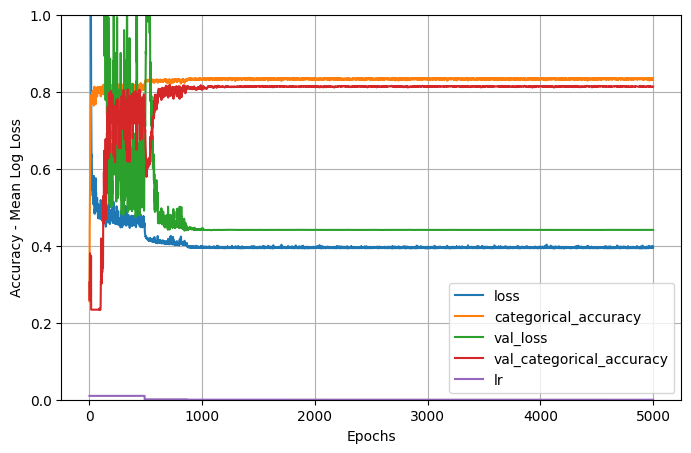

In [11]:
results=pd.DataFrame(history.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [12]:
training_accuracy = round(results.categorical_accuracy.values[-1:][0]*100, 2)
val_accuracy = round(results.val_categorical_accuracy.values[-1:][0]*100, 2)
training_error = round((1 - results.categorical_accuracy.values[-1:][0])*100, 2)
test_error = round((1 - results.val_categorical_accuracy.values[-1:][0])*100, 2)
human_error = 5
bias = round(training_error - human_error, 2)
variance = round(test_error - training_error, 2)
training_time = round(end_time - start_time)
print("Training accuracy: ", training_accuracy, "%")
print("Validationa accuracy", val_accuracy, "%")
print("Error (training):", training_error, "%")
print("Error (test):", test_error, "%")
print("Bias:", bias)
print("Variance:", variance)
print("Time: ", training_time, "seconds")

Training accuracy:  83.11 %
Validationa accuracy 81.33 %
Error (training): 16.89 %
Error (test): 18.67 %
Bias: 11.89
Variance: 1.78
Time:  463 seconds


In [13]:
def draw_confusion_matrix(cm, categories, normalize=True):
    # Draw confusion matrix
    fig = plt.figure(figsize=[3*pow(len(categories), 0.5), 2*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    if normalize:
        cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=categories, yticklabels=categories, ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(12-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)


51/51 [==============================] - 0s 3ms/step


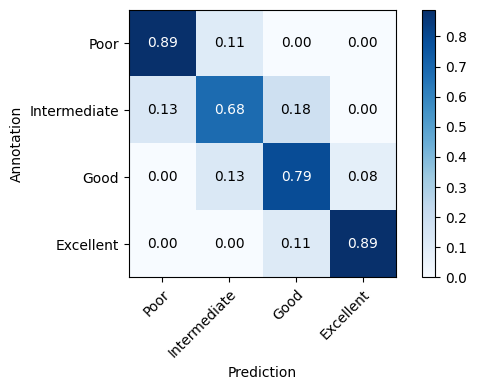

In [14]:
labels_pred = my_model.predict(instances_dev)
cm = confusion_matrix(np.argmax(labels_dev, axis=1), np.argmax(labels_pred, axis=1))
draw_confusion_matrix(cm, ["Poor", "Intermediate", "Good", "Excellent"])

## Step 8: Save results

In [15]:
RESULTS_FOLDER = "../Results"
RESULTS_FILE = f"{RESULTS_FOLDER}/models_performance.csv"

In [16]:
results_df = pd.read_csv(RESULTS_FILE, index_col = 0)

In [17]:
COLUMNS = [
    'model_name',
    'epochs',
    'learning_rate',
    'batch_size',
    'activation',
    'loss',
    'optimizer',
    'regularization',
    'initializer',
    'train_accuracy',
    'validation_accuracy',
    'bias',
    'variance',
    'training_time'
]

new_result = [[
    model_name,
    N_EPOCHS,
    LEARNING_RATE,
    BATCH_SIZE,
    ACTIVATION,
    "categorical_crossentropy",
    "ADAM 0.9 0.999",
    "L1L2",
    "He Uniform",
    training_accuracy,
    val_accuracy,
    bias,
    variance,
    training_time]]

new_result_df = pd.DataFrame(new_result, columns=COLUMNS)
concatenation = pd.concat([results_df, new_result_df], ignore_index=True)
concatenation.to_csv(RESULTS_FILE)


In [18]:
# last_five = results_df.tail(5)
last_five = concatenation.tail(5)
print(last_five)
print("\n---Metrics---")
print(last_five[["train_accuracy", "validation_accuracy", "bias", "variance", "training_time"]].describe())

                                           model_name  epochs  learning_rate  \
91  D512_DR_BN_D128_DR_BN_D32_DR_BN_D128_DR_BN_D51...     400          0.100   
92                                               D512     400          0.100   
93                              D128_BN_D64_BN_D32_BN     400          0.001   
94                                              final    5000          0.010   
95                                              final    5000          0.010   

    batch_size activation                      loss       optimizer  \
91         256        elu  categorical_crossentropy             SGD   
92         512       relu  categorical_crossentropy             SGD   
93         256       relu  categorical_crossentropy  ADAM 0.9 0.999   
94        4096       relu  categorical_crossentropy  ADAM 0.9 0.999   
95        4096       relu  categorical_crossentropy  ADAM 0.9 0.999   

   regularization  train_accuracy  validation_accuracy   bias  variance  \
91      l1 0.0001

In [19]:
MODELS_FOLDER = "../Models"
save_name = f"{MODELS_FOLDER}/{model_name}-2.h5"
my_model.save(save_name)